# Future City Temperature Predictions

In [2]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA

import pmdarima as pm #auto arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

ModuleNotFoundError: ignored

In [ ]:
pip install pmdarima

In [3]:
#This may need to be edited if it is exported from Jupyter
top_50_df = pd.read_csv('../../Data/Cleaned/top_50_us_city_temp.csv',
                            parse_dates=['dt'],
                            index_col=['dt'])
top_50_df

FileNotFoundError: ignored

## Please enter the city of interest below. Current city options are shown below.

In [ ]:
top_50_df['City'].unique()

In [ ]:
city_chosen = input("Please enter the city you want temperature predictions for: ")
print(f"You have chosen '{city_chosen}'. We will now get you future temperature predictions!")

In [ ]:
chosen_city_df = top_50_df[top_50_df['City'] == city_chosen]

In [ ]:
chosen_city_df

In [ ]:
temperature_df = chosen_city_df['AverageTemperature']
temperature_df = temperature_df.to_frame()
temperature_df

In [ ]:
#create differenced dataset
first_diff_df = temperature_df.diff().dropna()
first_diff_df.plot(color='blue')

In [ ]:
X = first_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Our data is showing stationary so we can proceed with modeling.

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(temperature_df, test_size=120, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 1244
No. of testing examples: 120


In [ ]:
train_data

,AverageTemperature
dt,
1900-02-01,17.393
1900-03-01,20.091
1900-04-01,22.646
1900-05-01,25.027
1900-06-01,26.875
...,...
2003-05-01,26.964
2003-06-01,27.855
2003-07-01,28.707


In [ ]:
test_data

,AverageTemperature
dt,
2003-10-01,25.641
2003-11-01,23.068
2003-12-01,17.085
2004-01-01,17.252
2004-02-01,19.641
...,...
2013-05-01,24.937
2013-06-01,27.893
2013-07-01,27.997


# Evaluator Function
We can use this to evaluate our different models

In [ ]:
def evaluate_model(model, test_data):
    # Make predictions
    predictions = model.predict(start=test_data.index[0], end=test_data.index[-1])

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(test_data, predictions)

    return mse, predictions

# Auto ARIMA
Note that our data was showing stationarity after doing a first order difference, which would indicate to us that the model does not have a seasonal component. However, we can let the auto ARIMA test whether we need to do differencing for trend and seasonality simply by setting d and D equal to "None". This will make our code more robust.

In [ ]:
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=None, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True, return_valid_fits=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=4981.629, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6908.617, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4411.763, Time=1.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5317.468, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11397.640, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5581.072, Time=0.12 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=3891.020, Time=1.49 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5060.698, Time=0.71 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=3958.171, Time=4.86 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=3902.993, Time=4.72 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=4833.327, Time=1.51 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=5.02 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=4146.594, Time=1.43 sec
 ARIMA(2,0,0)(1,0,1)[12] int

# Best ARIMA Models

We set return_valid_fits=True so we can now directly access the best models as the are stored in order of best to worst by the auto ARIMA. We will take the best 3 models.

In [ ]:
best_model = smodel[0]
second_best_model = smodel[1]
third_best_model = smodel[2]

In [ ]:
print(best_model)
print(second_best_model)
print(third_best_model)

 ARIMA(1,0,0)(1,0,1)[12] intercept
 ARIMA(1,0,0)(1,0,2)[12] intercept
 ARIMA(1,0,0)(2,0,1)[12] intercept


In [ ]:
best_order = smodel[0].order
best_order_seasonal = smodel[0].seasonal_order

second_best_order = smodel[1].order
second_best_order_seasonal = smodel[1].seasonal_order


third_best_order = smodel[2].order
third_best_order_seasonal = smodel[2].seasonal_order

In [ ]:
print(best_order,best_order_seasonal)
print(second_best_order,second_best_order_seasonal)
print(third_best_order,third_best_order_seasonal)

(1, 0, 0) (1, 0, 1, 12)
(1, 0, 0) (1, 0, 2, 12)
(1, 0, 0) (2, 0, 1, 12)


In [ ]:
best_model = SARIMAX(train_data, order=best_order, seasonal_order=best_order_seasonal)
best_model_fit = best_model.fit(disp=False)

/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
second_best_model = SARIMAX(train_data ,order=second_best_order, seasonal_order=second_best_order_seasonal)
second_best_model_fit = second_best_model.fit(disp=False)

/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [ ]:
third_best_model = SARIMAX(train_data, order=third_best_order, seasonal_order=third_best_order_seasonal)
third_best_model_fit = third_best_model.fit(disp=False)

/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
mse_best_model, predictions_best_model = evaluate_model(best_model_fit, test_data)

In [ ]:
mse_second_best_model, predictions_second_best_model = evaluate_model(second_best_model_fit, test_data)

In [ ]:
mse_third_best_model, predictions_third_best_model = evaluate_model(third_best_model_fit, test_data)

# Exponential Smoothing Models

In [ ]:
ets_model_add_add = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12)



/Users/merrill/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
ets_model_add_add_fit = ets_model_add_add.fit()

In [ ]:
mse_ets_add_add, predictions_ets_add_add = evaluate_model(ets_model_add_add_fit, test_data)

NOTE: If we want to use multiplicative we need to do some data transformation. We may want to run a model with our trend = 'mul' since we may be thinking of things like gloabl warming. However, we do not need seasonal = 'mul'.

In [ ]:
# ets_model_add_add = ExponentialSmoothing(train_data, trend='mul', seasonal='add', seasonal_periods=12)
# #ets_model_add_add_fit = ets_model_add_add.fit()

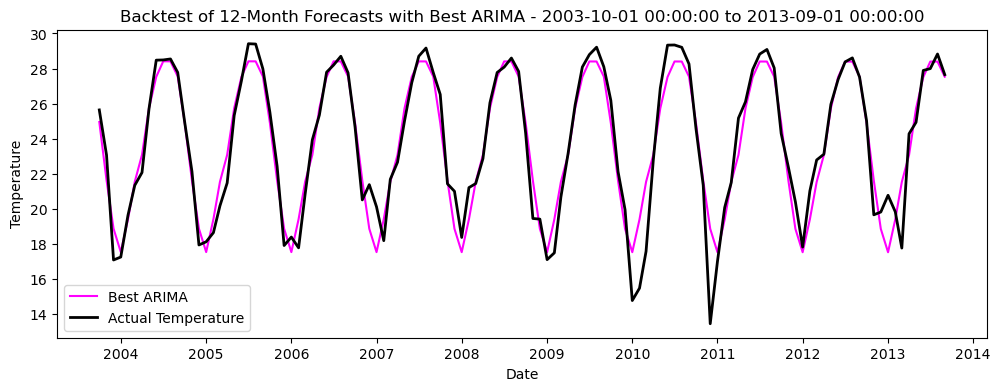

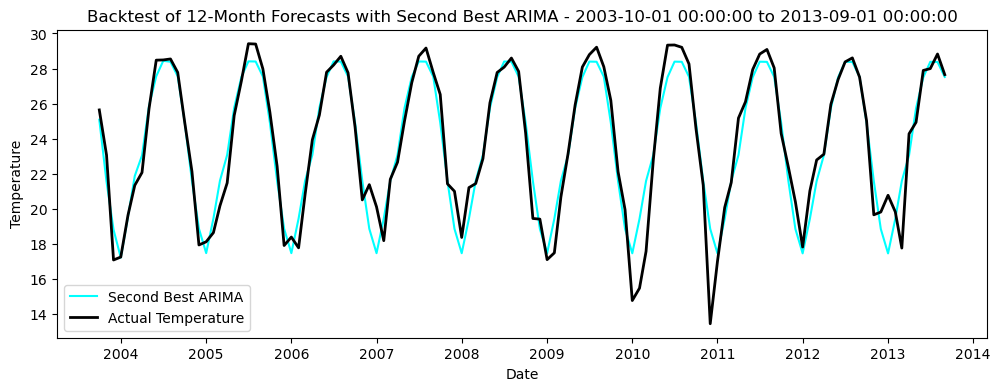

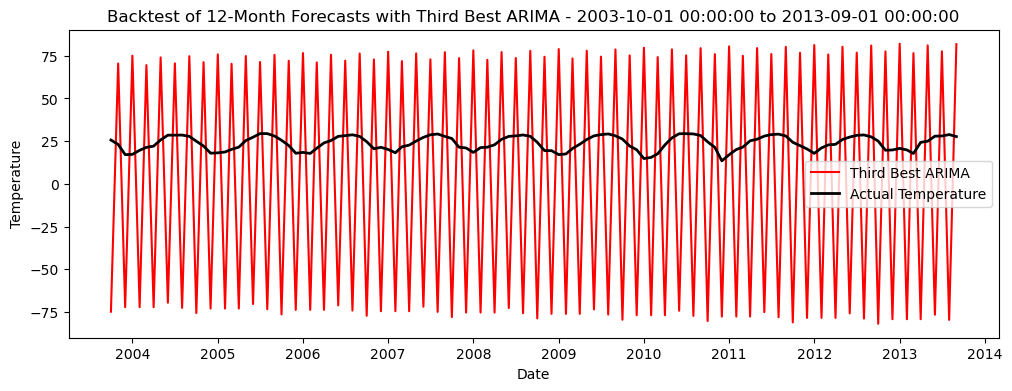

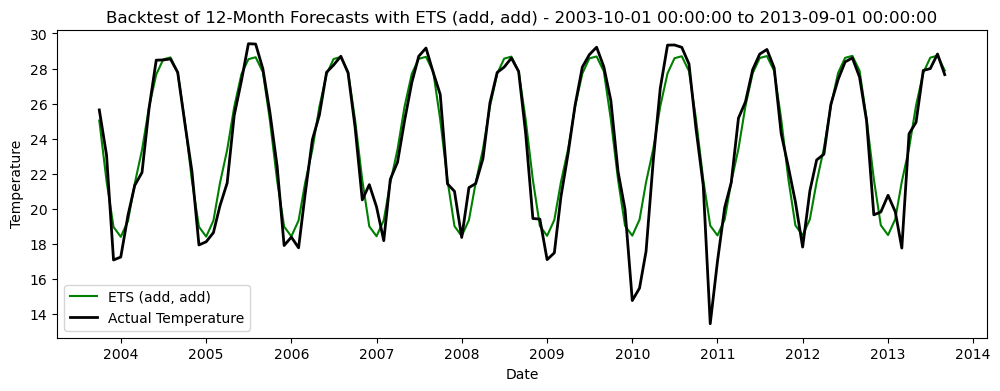

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(test_data.index, predictions_best_model, label='Best ARIMA', color = "magenta")
plt.plot(test_data.index, test_data['AverageTemperature'], label='Actual Temperature', color='black', linewidth=2)
plt.title(f'Backtest of 12-Month Forecasts with Best ARIMA - {test_data.index[0]} to {test_data.index[-1]}')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.savefig("Best_ARIMA")
plt.show()

# Plot for ARIMA model 2 "Second Best"
plt.figure(figsize=(12, 4))
plt.plot(test_data.index, predictions_second_best_model, label='Second Best ARIMA', color = "cyan")
plt.plot(test_data.index, test_data['AverageTemperature'], label='Actual Temperature', color='black', linewidth=2)
plt.title(f'Backtest of 12-Month Forecasts with Second Best ARIMA - {test_data.index[0]} to {test_data.index[-1]}')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Plot for ARIMA model 3 "Third Best"
plt.figure(figsize=(12, 4))
plt.plot(test_data.index, predictions_third_best_model, label='Third Best ARIMA', color = "red")
plt.plot(test_data.index, test_data['AverageTemperature'], label='Actual Temperature', color='black', linewidth=2)
plt.title(f'Backtest of 12-Month Forecasts with Third Best ARIMA - {test_data.index[0]} to {test_data.index[-1]}')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(test_data.index, predictions_ets_add_add, label='ETS (add, add)', color = "green")
plt.plot(test_data.index, test_data['AverageTemperature'], label='Actual Temperature', color='black', linewidth=2)
plt.title(f'Backtest of 12-Month Forecasts with ETS (add, add) - {test_data.index[0]} to {test_data.index[-1]}')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.savefig("ETS")
plt.show()


In [ ]:
print(f"MSE for the best ARIMA model: {mse_best_model}")
print(f"MSE for the second best ARIMA model: {mse_second_best_model}")
print(f"MSE for the third best ARIMA model: {mse_third_best_model}")
print(f"MSE for the first best ETS model: {mse_ets_add_add}")

MSE for the best ARIMA model: 1.57047618687549
MSE for the second best ARIMA model: 1.5880549016536218
MSE for the third best ARIMA model: 6350.773494348992
MSE for the first best ETS model: 1.5294137288623986
